# Free Recall

In [99]:
import math

def wilson_ci(k, n, z=1.96):
    if n == 0:
        return (float('nan'), float('nan'))
    p = k / n
    denom = 1 + (z**2) / n
    center = (p + (z**2) / (2 * n)) / denom
    half_width = (z * math.sqrt((p * (1 - p) + (z**2) / (4 * n)) / n)) / denom
    return (center - half_width, center + half_width)

Read all files (trials) in the specified folder and for each of them calculate the number of correct guesses and the corresponding flags (1 in the position of samples correctly guessed in any position).

In [100]:
import pandas as pd
from pathlib import Path

base = Path('..') / 'data' / 'free'

# process the root batch and each immediate subfolder
modifiers = [base] + sorted([p for p in base.iterdir() if p.is_dir()])

# collect results for every batch (no printing / plotting here)
results = {}
for mod in modifiers:
    res = []
    for trial in sorted(mod.glob('*.csv')):
        df = pd.read_csv(trial)
        guesses = set(df['guess'].dropna().astype(str))
        samples = df['sample'].astype(str)
        binaries = [1 if s in guesses else 0 for s in samples]
        total_correct = sum(binaries)
        res.append({'file': str(trial), 'counts': total_correct, 'binaries': binaries})

    results[mod.name] = res

Computes per-trial and overall summary statistics (mean, population variance, overall proportion and Wilson 95% CI) of correct guesses and prints them.

In [101]:
import pandas as pd

# Build a summary table with one row per modifier
summary_rows = []
for mod, res in results.items():
    counts = [r['counts'] for r in res]
    mean_counts = sum(counts) / len(counts) if len(counts) > 0 else float('nan')

    total_successes = sum(r['counts'] for r in res)
    total_positions = sum(len(r['binaries']) for r in res)
    proportion = total_successes / total_positions if total_positions > 0 else float('nan')
    ci = wilson_ci(total_successes, total_positions)

    # primacy (first 3), recency (last 3), middle (positions 4..17)
    ps = sum(sum(int(b) for b in r['binaries'][:3]) for r in res)
    pn = sum(min(3, len(r['binaries'])) for r in res)
    rs = sum(sum(int(b) for b in r['binaries'][-3:]) for r in res)
    rn = pn
    ms = sum(sum(int(b) for b in r['binaries'][3:17]) for r in res)
    mn = sum(max(0, min(17, len(r['binaries'])) - 3) for r in res)

    prim_ci = wilson_ci(ps, pn)
    rec_ci = wilson_ci(rs, rn)
    mid_ci = wilson_ci(ms, mn)

    summary_rows.append({
        'modifier': mod,
        'mean_counts': mean_counts,
        'proportion': proportion,
        'ci': ci,
        'prim_ci': prim_ci,
        'rec_ci': rec_ci,
        'mid_ci': mid_ci,
    })

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df[[ 'modifier', 'mean_counts', 'proportion', 'ci', 'prim_ci', 'rec_ci', 'mid_ci']]
summary_df

,modifier,mean_counts,proportion,ci,prim_ci,rec_ci,mid_ci
0,free,5.900,0.29500,"(0.26443794022318257, 0.3275214706856333)","(0.3245599028350716, 0.4977938135251822)","(0.5783093452093498, 0.744683897772007)","(0.16065687253278665, 0.22569560660319754)"
1,delay,4.975,0.24875,"(0.22004221844340033, 0.27985925468264844)","(0.18837283808050675, 0.343286959596526)","(0.5105585981828253, 0.6832373476059888)","(0.14247791039391183, 0.20485651828251072)"
2,rate,6.450,0.32250,"(0.2910231774471024, 0.35567338565687234)","(0.30124387764148153, 0.47266085227156884)","(0.6924293655773726, 0.8405094853418662)","(0.180635838150289, 0.2482817869415807)"
3,task,3.075,0.15375,"(0.1304138482392468, 0.18039564457625318)","(0.1738573324150334, 0.32550314096386357)","(0.13124933052612614, 0.2712131699583638)","(0.10174647092037326, 0.15691057034795453)"


CI evaluation

In [102]:
# Print all pairs of modifiers whose confidence intervals do not overlap (overall proportion)
for i in range(len(summary_df)):
    for j in range(i + 1, len(summary_df)):
        ci_i_low, ci_i_high = summary_df.iloc[i]['ci']
        ci_j_low, ci_j_high = summary_df.iloc[j]['ci']
        # Check if intervals do not overlap
        if ci_i_high < ci_j_low or ci_j_high < ci_i_low:
            print(f"CI not overlapping: {summary_df.iloc[i]['modifier']} vs {summary_df.iloc[j]['modifier']}")

print()

# Print primacy vs recency vs middle confidence interval overlaps
for _, row in summary_df.iterrows():
    prim_low, prim_high = row['prim_ci']
    rec_low, rec_high = row['rec_ci']
    mid_low, mid_high = row['mid_ci']
    outs = []
    if prim_high < rec_low or rec_high < prim_low:
        outs.append("primacy vs recency")
    if prim_high < mid_low or mid_high < prim_low:
        outs.append("primacy vs middle")
    if rec_high < mid_low or mid_high < rec_low:
        outs.append("recency vs middle")
    if outs:
        print(f"{row['modifier']}: no overlap between " + ", ".join(outs))

CI not overlapping: free vs task
CI not overlapping: delay vs rate
CI not overlapping: delay vs task
CI not overlapping: rate vs task

free: no overlap between primacy vs recency, primacy vs middle, recency vs middle
delay: no overlap between primacy vs recency, recency vs middle
rate: no overlap between primacy vs recency, primacy vs middle, recency vs middle
task: no overlap between primacy vs middle


Plot the frequency of each correct guess based on the position

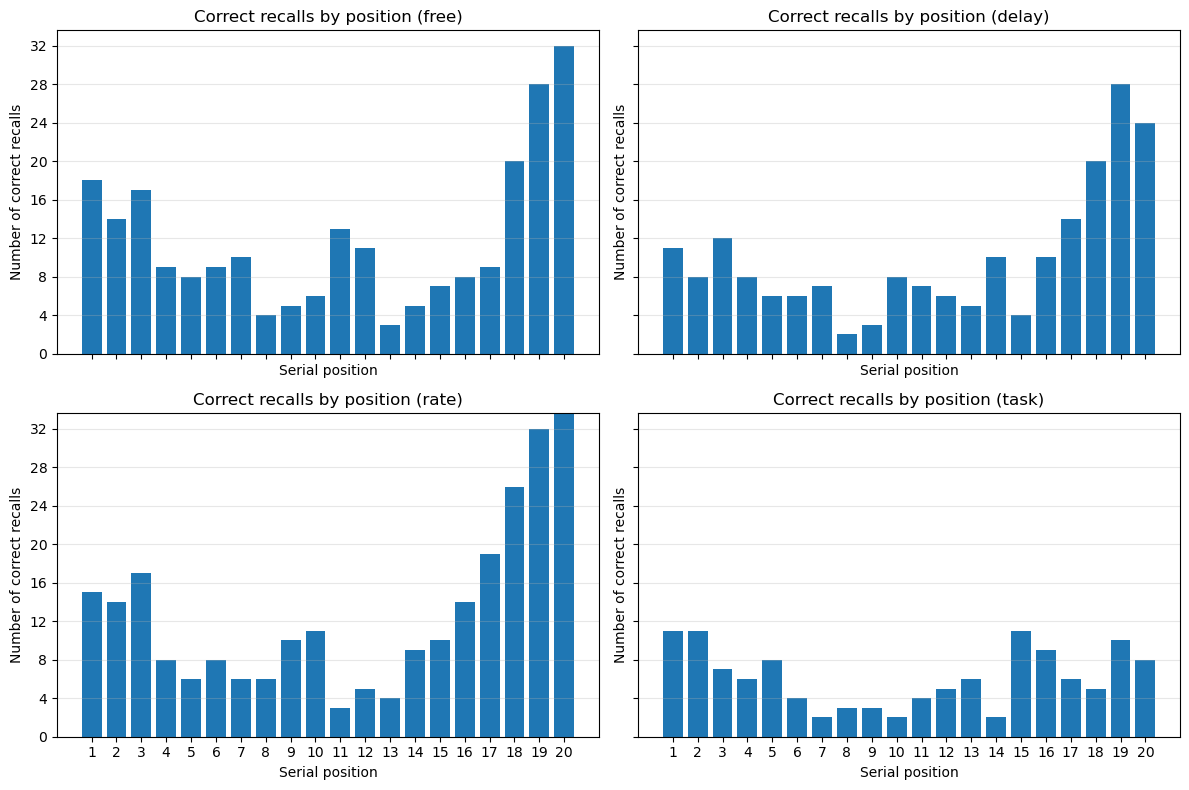

In [103]:
from matplotlib.ticker import MaxNLocator

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Plot serial-position bar charts for each modifier in a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

positions = list(range(1, 21))

for ax, (mod, res) in zip(axs, results.items()):
    # position counts (1..20)
    pos_counts = [0] * 20
    for r in res:
        bins = r['binaries']
        for i in range(min(20, len(bins))):
            pos_counts[i] += int(bins[i])

    ax.bar(positions, pos_counts)
    ax.set_xlabel('Serial position')
    ax.set_ylabel('Number of correct recalls')
    ax.set_xticks(positions)
    ax.set_title(f'Correct recalls by position ({mod})')
    ax.grid(axis='y', alpha=0.3)

    # ensure y-axis uses integer ticks and starts at 0
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(bottom=0)

# If there are any unused axes (fewer than 4 modifiers), hide them
for ax in axs[len(results):]:
    ax.axis('off')

plt.tight_layout()
plt.show()